# Graded lab session 5 | Deep classification on Fashion-MNIST using pytorch

pierre-henri.conze@imt-atlantique.fr

francois.rousseau@imt-atlantique.fr


---



#### **Student name** = [TO BE COMPLETED]

### Objective of this lab session: perform classification on Fashion-MNIST using multi-layer perceptron, convolutional neural networks and transfer learning to obtain the best classification results as possible.

#### Challenge: the first 3 students in terms of overall test accuracy results (whatever the methodology used) will obtain bonus points!

### Table of Contents

* [Data management](#section_1)
    * [Question 1.1](#question_1_1)
    * [Question 1.2](#question_1_2)
    * [Question 1.3](#question_1_3)
    * [Question 1.4](#question_1_4)
* [Multi-Layer Perceptron](#section_2)    
    * [Question 2.1](#question_2_1)
    * [Question 2.2](#question_2_2)
    * [Question 2.3](#question_2_3)
    * [Question 2.4](#question_2_4)
    * [Question 2.5](#question_2_5)
* [Convolutional neural network](#section_3)    
    * [Question 3.1](#question_3_1)
    * [Question 3.2](#question_3_2)
    * [Question 3.3](#question_3_3)
    * [Question 3.4](#question_3_4)
    * [Question 3.5](#question_3_5)
    * [Question 3.6](#question_3_6)
    * [Question 3.7](#question_3_7)
* [Transfer learning from ImageNet](#section_4)    
    * [Question 4.1](#question_4_1)
    * [Question 4.2](#question_4_2)
    * [Question 4.3](#question_4_3)
    * [Question 4.4](#question_4_4)
    * [Question 4.5](#question_4_5)
* [Challenge](#section_5)    
    * [Question 5.1](#question_5_1)

## 1- Data management <a class="anchor" id="section_1"></a>

Start with these lines of code to automatically download the Fashion-MNIST dataset.

In [1]:
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.FashionMNIST(root = 'data', train = False, download = True, transform = transform)

As indicated below, each Fashion-MNIST sample is assigned to one of the following classes: 0: T-shirt/top, 1: Trouser, 2: Pullover, 3: Dress, 4: Coat, 5: Sandal, 6: Shirt, 7: Sneaker, 8: Bag, 9: Ankle boot.

In [2]:
class_names = train_data.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


#### **Question 1.2** - Complete the following cell to create data loaders ([documentation](https://pytorch.org/docs/stable/data.html)) for training, validation and test sets. <a class="anchor" id="question_1_2"></a>

In [3]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

batch_size = 20
valid_size = 0.2

def create_data_loaders(batch_size, valid_size, train_data, test_data): # FUNCTION TO BE COMPLETED
  num_train = len(train_data)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)
  indices = list(range(num_train))
  np.random.shuffle(indices)
  split = int(np.floor(valid_size * num_train))
  train_index, valid_index = indices[split:], indices[:split]

  # define samplers for obtaining training and validation batches
  train_sampler = SubsetRandomSampler(train_index)
  valid_sampler = SubsetRandomSampler(valid_index)

  # prepare data loaders
  train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
  valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler)
  return train_loader, valid_loader, test_loader

In [4]:
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data) 

#### **Question 1.3** - Visualize some images from the training set with corresponding ground truth labels. <a class="anchor" id="question_1_3"></a>

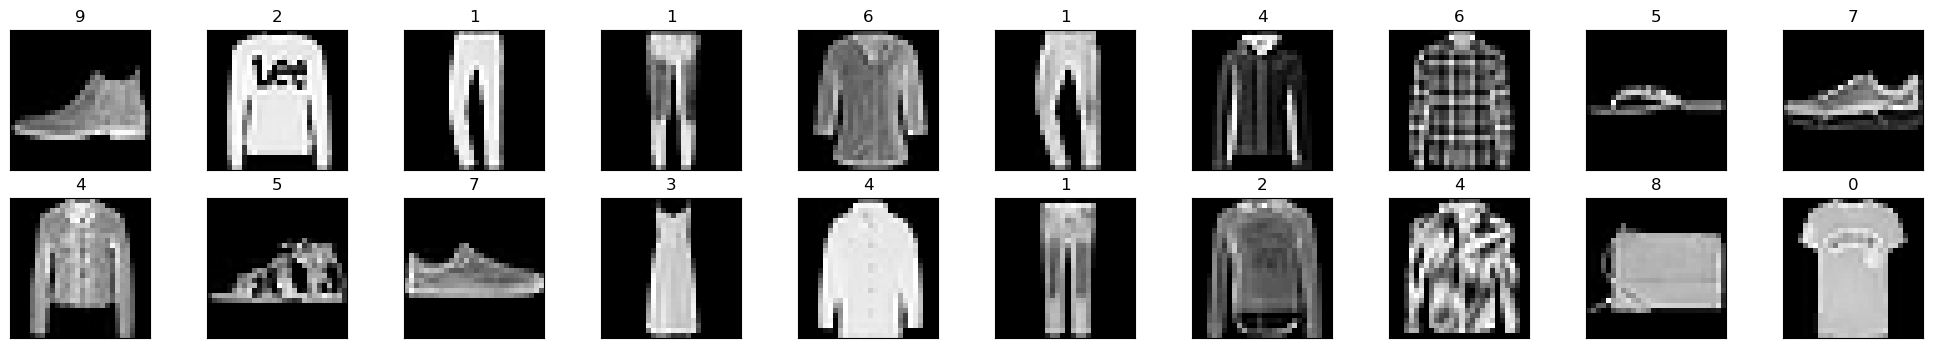

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data_iter = iter(test_loader) 
images, labels = next(data_iter) # obtain one batch from the test set
images = images.numpy()
# plot images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray') # .npsqueeze removes single-dimensional entries from the shape of an array
    ax.set_title(str(labels[idx].item())) # .item() gets the value contained in a Tensor






#### **Question 1.4** - View one of these images with more details by superimposing the greyscale intensity values directly on it. <a class="anchor" id="question_1_4"></a>

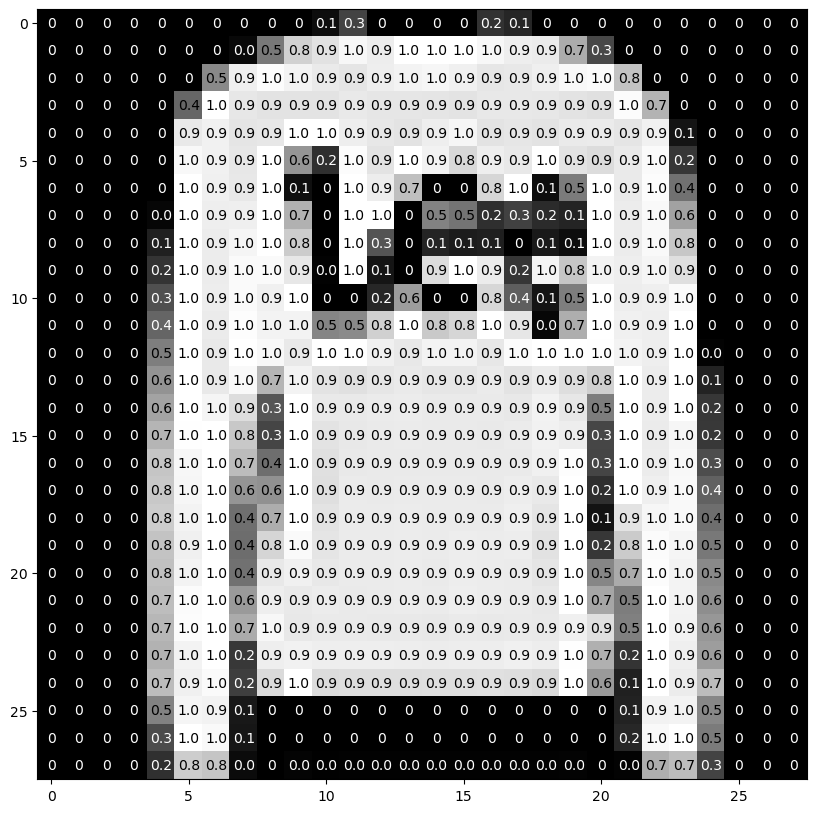

In [6]:
img = np.squeeze(images[1])
fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],1) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x), horizontalalignment='center', verticalalignment='center', color='white' if img[x][y]<thresh else 'black')






## 2- Multi-Layer Perceptron (MLP) <a class="anchor" id="section_2"></a>

First, let us use a multi-layer perceptron (MLP) to automatically classify Fashion-MNIST images.

#### **Question 2.1** - Define a MPL architecture with (at least) 2 fully-connected as well as dropout layers. <a class="anchor" id="question_2_1"></a>

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self): # FUNCTION TO BE COMPLETED
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(400, 10)

    def forward(self,x): # FUNCTION TO BE COMPLETED
        x = x.view(-1,28*28)
        self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x= self.fc2(x)
        return x

#### **Question 2.2** - Train the pre-defined MPL network with cross entropy as loss function and stochastic gradient descent as optimization algorithm. <a class="anchor" id="question_2_2"></a>

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cpu


In [9]:
model_1 = MLP()
model_1.to(device=device)

MLP(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=400, out_features=10, bias=True)
)

In [10]:
#DEFINE THE CRITERION
criterion = nn.CrossEntropyLoss()

In [11]:
#DEFINE THE OPTIMIZER
optimizer = torch.optim.SGD(model_1.parameters(),lr = 0.01)

In [12]:
n_epochs = 30

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer): # FUNCTION TO BE COMPLETED

  train_losses, valid_losses = [], []
  valid_loss_min = np.Inf

  for epoch in range(n_epochs):
      train_loss, valid_loss = 0, 0

      model.train()
      for data, label in train_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)
          #TO BE COMPLETED
          optimizer.zero_grad() # clear the gradients of all optimized variables
          output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
          loss = criterion(output, label) # calculate the loss
          loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
          optimizer.step() # perform a single optimization step (parameter update)
          train_loss += loss.item() * data.size(0) # update running training loss





      model.eval()
      for data, label in valid_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)
          #TO BE COMPLETED
          with torch.no_grad():
              output = model(data)
          loss = criterion(output,label)
          valid_loss += loss.item() * data.size(0)



      train_loss /= len(train_loader.sampler)
      valid_loss /= len(valid_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), 'model.pt')
          valid_loss_min = valid_loss

  return train_losses, valid_losses

In [13]:
#RUN THE TRAINING FUNCTION
train_losses_1, valid_losses_1 = training(n_epochs, train_loader, valid_loader, model_1, criterion, optimizer)

epoch: 1 	training Loss: 0.820154 	validation Loss: 0.582336
validation loss decreased (inf --> 0.582336).  Saving model ...
epoch: 2 	training Loss: 0.525078 	validation Loss: 0.492124
validation loss decreased (0.582336 --> 0.492124).  Saving model ...
epoch: 3 	training Loss: 0.474044 	validation Loss: 0.462831
validation loss decreased (0.492124 --> 0.462831).  Saving model ...
epoch: 4 	training Loss: 0.445895 	validation Loss: 0.443136
validation loss decreased (0.462831 --> 0.443136).  Saving model ...
epoch: 5 	training Loss: 0.425543 	validation Loss: 0.434209
validation loss decreased (0.443136 --> 0.434209).  Saving model ...
epoch: 6 	training Loss: 0.410529 	validation Loss: 0.418218
validation loss decreased (0.434209 --> 0.418218).  Saving model ...
epoch: 7 	training Loss: 0.397423 	validation Loss: 0.412327
validation loss decreased (0.418218 --> 0.412327).  Saving model ...
epoch: 8 	training Loss: 0.385829 	validation Loss: 0.425392
epoch: 9 	training Loss: 0.375944 

#### **Question 2.3** - Plot the evolution of the loss function for both training and validation sets with respect to epochs to study the convergence of the training process. <a class="anchor" id="question_2_3"></a>

Text(0, 0.5, 'loss value')

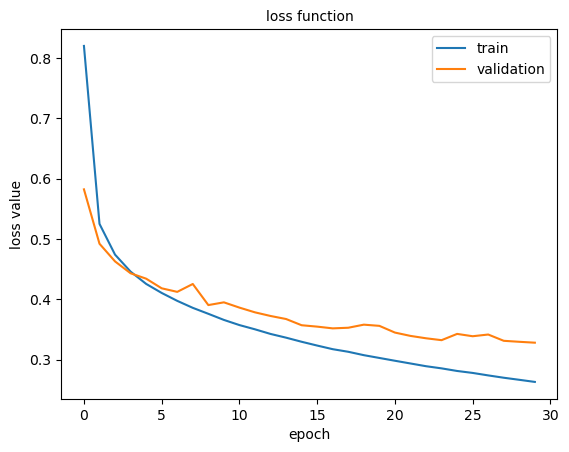

In [14]:

plt.plot(range(n_epochs), train_losses_1)
plt.plot(range(n_epochs), valid_losses_1)
plt.legend(['train', 'validation'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)


Let us load the model corresponding to the lowest validation loss.

In [15]:
model_1.load_state_dict(torch.load('model.pt', map_location=device))

<All keys matched successfully>

#### **Question 2.4** - Test the best model on (unseen) test data and evaluate it’s performance in terms of overall and per-class accuracy scores. <a class="anchor" id="question_2_4"></a>

In [16]:
def evaluation(model, test_loader, criterion):

  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))

  model.eval()
  for data, label in test_loader:
      data = data.to(device=device, dtype=torch.float32)
      label = label.to(device=device, dtype=torch.long)
      with torch.no_grad():
          output = model(data)
      loss = criterion(output, label)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)
      correct = np.squeeze(pred.eq(label.data.view_as(pred)))
      for i in range(len(label)):
          digit = label.data[i]
          class_correct[digit] += correct[i].item()
          class_total[digit] += 1

  test_loss = test_loss/len(test_loader.sampler)
  print('test Loss: {:.6f}\n'.format(test_loss))
  for i in range(10):
      print('test accuracy of %s: %2d%% (%2d/%2d)' % (class_names[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
  print('\ntest accuracy (overall): %2.2f%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

In [17]:
evaluation(model_1, test_loader, criterion)

test Loss: 0.343818

test accuracy of T-shirt/top: 78% (784/1000)
test accuracy of Trouser: 97% (971/1000)
test accuracy of Pullover: 82% (825/1000)
test accuracy of Dress: 89% (898/1000)
test accuracy of Coat: 81% (817/1000)
test accuracy of Sandal: 94% (946/1000)
test accuracy of Shirt: 65% (654/1000)
test accuracy of Sneaker: 94% (943/1000)
test accuracy of Bag: 96% (968/1000)
test accuracy of Ankle boot: 96% (960/1000)

test accuracy (overall): 87.66% (8766/10000)


#### **Question 2.5** - Visualize some incorrect predictions by displaying test images and labels in the format: "predicted (ground-truth)". <a class="anchor" id="question_2_5"></a>

In [18]:
def get_all_prediction(model, loader):
    preds = torch.tensor([], dtype=torch.long)
    targets = torch.tensor([], dtype=torch.long)
    for data, label in loader:
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.long)
        with torch.no_grad():
            output = model(data)
        targets = torch.cat((targets, label.cpu()), dim = 0)
        preds = torch.cat((preds, torch.max(output.cpu(), 1)[1]), dim = 0)
    return targets.numpy(), preds.numpy()

In [19]:
targets, preds_1 = get_all_prediction(model_1, test_loader)

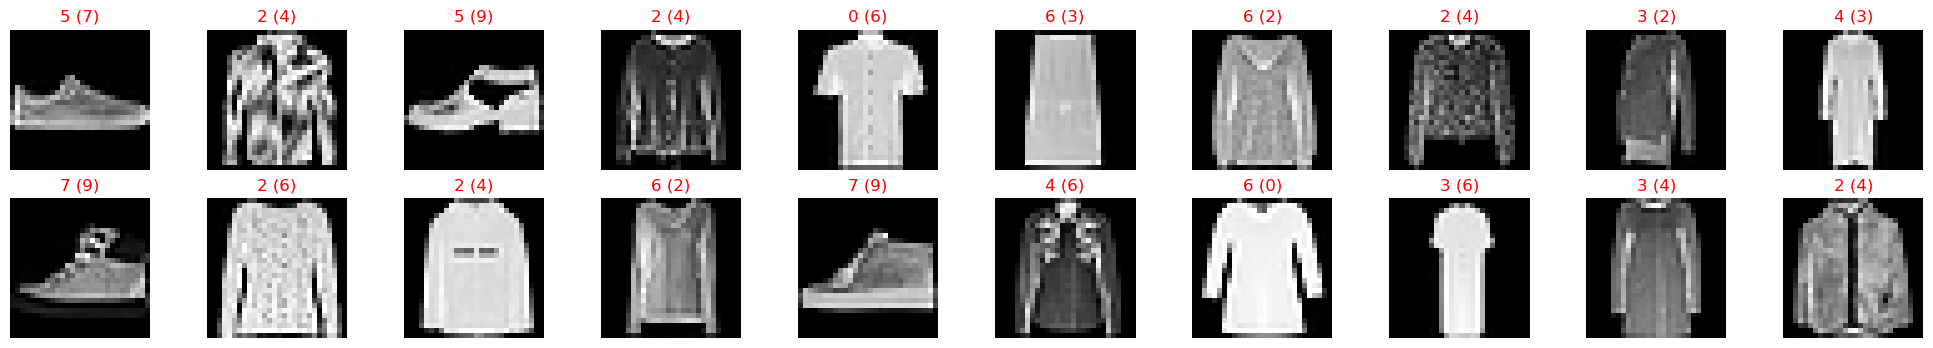

In [20]:
index = np.where(preds_1 - targets != 0)[0]
test_set_array = test_data.data.numpy()
plt.figure(figsize=(25, 4))
for i in range(20):
  plt.subplot(2, 10, i + 1)
  plt.axis('off')
  plt.imshow(test_set_array[index[i],:,:], cmap='gray')
  plt.title("{} ({})".format(str(int(preds_1[index[i]])), str(int(targets[index[i]]))),color=("red"))
plt.show()

## 3- Convolutional neural network (CNN) <a class="anchor" id="section_3"></a>

Let us now switch from MLP to convolutional neural network (CNN) to classify Fashion-MNIST images.

#### **Question 3.1** - Define a CNN architecture using (at least) 2 patterns [CONV - CONV - POOL] as well as dropout and fully-connected layers. <a class="anchor" id="question_3_1"></a>

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):

    def __init__(self): # FUNCTION TO BE COMPLETED
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 3, stride=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(4, 4, 3, stride=1)
        self.max_pool = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(4, 4, 3, stride=1)
        self.conv4 = nn.Conv2d(4, 4, 3, stride=1)
        self.fc = nn.Linear(4*4*4, 10)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self,x): # FUNCTION TO BE COMPLETED
        x= self.dropout(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x= self.max_pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x= self.max_pool(x)
        x= self.dropout(x)
        x = x.view(-1, 4*4*4)
        out= self.fc(x)
        return out

#### **Question 3.2** - Describe input/output sizes of each layer using summary() from torchsummary. <a class="anchor" id="question_3_2"></a>

In [22]:
#from torchsummary import summary

model_2 = CNN()
model_2.to(device=device)

# CALL THE SUMMARY FUNCTION TO DISPLAY THE ARCHITECTURE


CNN(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

#### **Question 3.3** - Train the pre-defined CNN network with cross entropy as loss function and stochastic gradient descent as optimization algorithm. <a class="anchor" id="question_3_3"></a>

In [23]:
#DEFINE THE OPTIMIZER
criterion = nn.CrossEntropyLoss() # specify loss function (categorical cross-entropy)
optimizer = torch.optim.SGD(model_2.parameters(),lr = 0.01) # specify optimizer (stochastic gradient descent) and learning rate

In [24]:
#RUN THE TRAINING FUNCTION
train_losses_2, valid_losses_2 =  training(n_epochs, train_loader, valid_loader, model_2, criterion, optimizer)

epoch: 1 	training Loss: 1.567410 	validation Loss: 0.818792
validation loss decreased (inf --> 0.818792).  Saving model ...
epoch: 2 	training Loss: 0.807357 	validation Loss: 0.658541
validation loss decreased (0.818792 --> 0.658541).  Saving model ...
epoch: 3 	training Loss: 0.727875 	validation Loss: 0.622870
validation loss decreased (0.658541 --> 0.622870).  Saving model ...
epoch: 4 	training Loss: 0.685209 	validation Loss: 0.594879
validation loss decreased (0.622870 --> 0.594879).  Saving model ...
epoch: 5 	training Loss: 0.649086 	validation Loss: 0.563884
validation loss decreased (0.594879 --> 0.563884).  Saving model ...
epoch: 6 	training Loss: 0.633599 	validation Loss: 0.554580
validation loss decreased (0.563884 --> 0.554580).  Saving model ...
epoch: 7 	training Loss: 0.620006 	validation Loss: 0.538193
validation loss decreased (0.554580 --> 0.538193).  Saving model ...
epoch: 8 	training Loss: 0.608783 	validation Loss: 0.532042
validation loss decreased (0.53819

#### **Question 3.4** - Display in a single graph the loss functions for training and validation sets obtained with both MLP and CNN models. <a class="anchor" id="question_3_4"></a>

Text(0, 0.5, 'loss value')

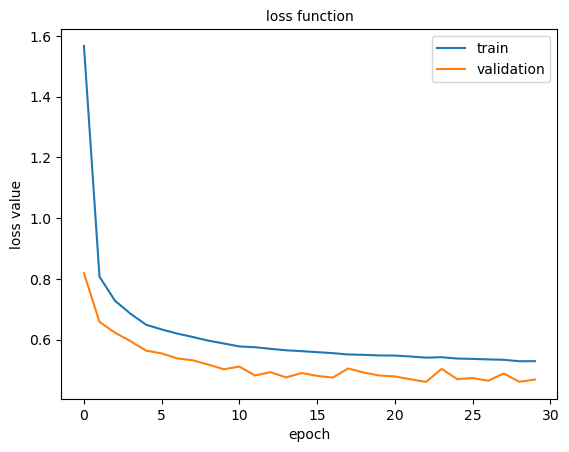

In [25]:
plt.plot(range(n_epochs), train_losses_2)
plt.plot(range(n_epochs), valid_losses_2)
plt.legend(['train', 'validation'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)

As previously, we load the model corresponding to the lowest validation loss.

In [26]:
model_2.load_state_dict(torch.load('model.pt', map_location=device))

<All keys matched successfully>

#### **Question 3.5** - Test the model on test data and evaluate it through overall and per-class accuracy scores. Compare these scores with the ones obtained using MLP. <a class="anchor" id="question_3_5"></a>

In [27]:
#RUN THE EVALUATION FUNCTION
evaluation(model_2, test_loader, criterion)

test Loss: 0.480979

test accuracy of T-shirt/top: 77% (779/1000)
test accuracy of Trouser: 95% (955/1000)
test accuracy of Pullover: 71% (711/1000)
test accuracy of Dress: 79% (796/1000)
test accuracy of Coat: 81% (815/1000)
test accuracy of Sandal: 92% (922/1000)
test accuracy of Shirt: 44% (448/1000)
test accuracy of Sneaker: 92% (920/1000)
test accuracy of Bag: 92% (922/1000)
test accuracy of Ankle boot: 96% (960/1000)

test accuracy (overall): 82.28% (8228/10000)


In [28]:
#RUN THE GET_ALL_PREDICTION FUNCTION
targets, preds_2 =  get_all_prediction(model_2, test_loader)

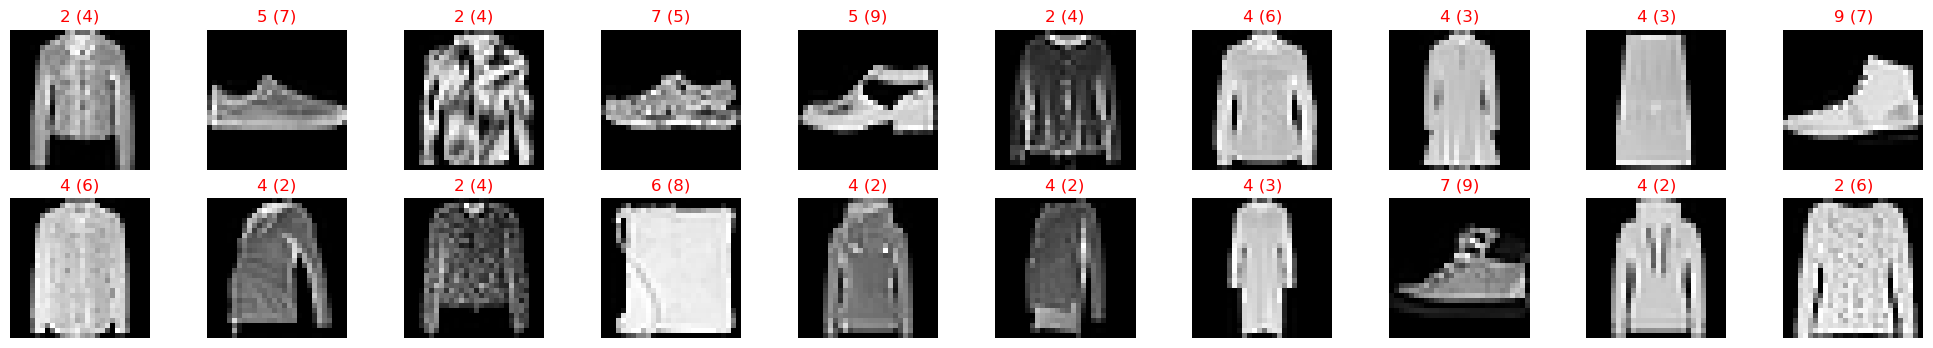

In [29]:
index = np.where(preds_2 - targets != 0)[0]
test_set_array = test_data.data.numpy()
plt.figure(figsize=(25, 4))
for i in range(20):
  plt.subplot(2, 10, i + 1)
  plt.axis('off')
  plt.imshow(test_set_array[index[i],:,:], cmap='gray')
  plt.title("{} ({})".format(str(int(preds_2[index[i]])), str(int(targets[index[i]]))),color=("red"))
plt.show()

#### **Question 3.7** - Display the confusion matrix for both MLP and CNN models. <a class="anchor" id="question_3_7"></a>

In [30]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='confusion matrix', cmap=plt.cm.Blues):
    # This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("normalized confusion matrix")
    else:
        print('confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('predicted label')

normalized confusion matrix


C:\Users\kaddy\AppData\Local\Temp\ipykernel_21432\2240654637.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)
C:\Users\kaddy\AppData\Local\Temp\ipykernel_21432\890170392.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


normalized confusion matrix


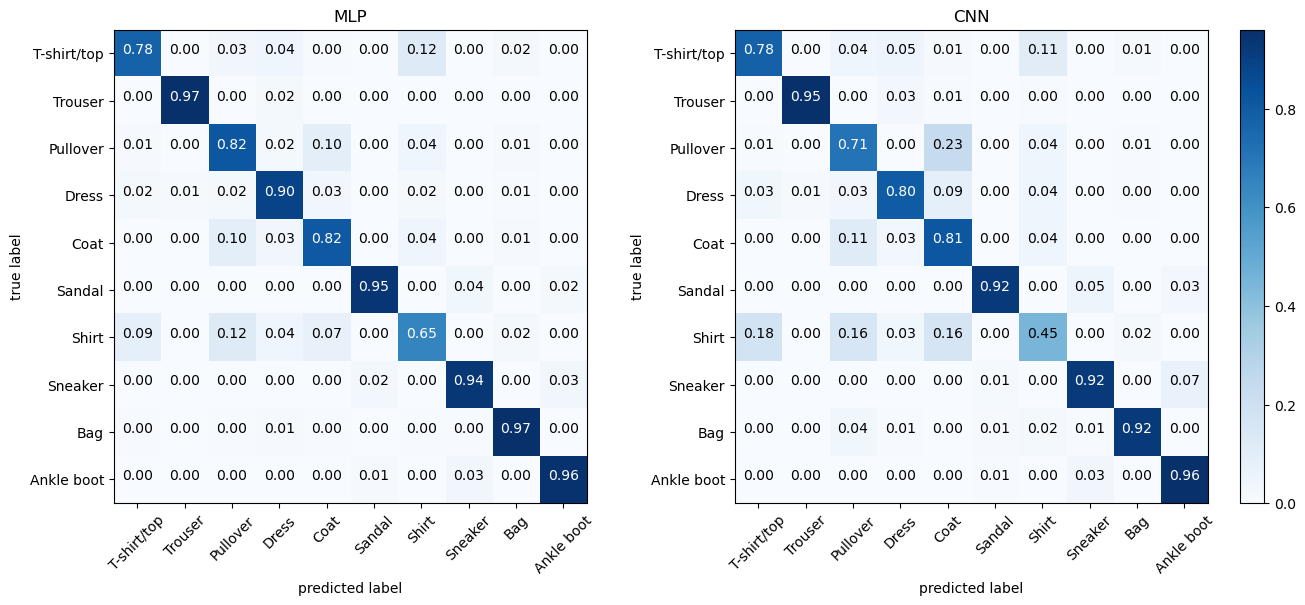

In [31]:
# compute confusion matrix
cnf_matrix_MLP = confusion_matrix(targets, preds_1)
cnf_matrix_CNN =confusion_matrix(targets, preds_2)
np.set_printoptions(precision=2)

# plot normalized confusion matrixes
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix_MLP, classes=class_names, normalize=True, title='MLP')
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix_CNN, classes=class_names, normalize=True, title='CNN')
plt.show()

## 4- Transfer learning from ImageNet <a class="anchor" id="section_4"></a>

Transfer learning focuses on storing knowledge gained while solving one problem and applying it to a different but related problem.

Our goal is to use a (well-known) CNN architecture whose weights have been already trained on ImageNet to perform transfer learning and fine tuning. ImageNet is a large visual database designed for visual object recognition purposes wich contains more than 14 million images!

#### **Question 4.1** - Modify the Fashion-MNIST dataset to make it fit to  ImageNet by extending Fashion-MNIST images from greyscale to 3-channels images. Since the minimal image dimension as inputs of pre-trained CNN models is 48x48, you will also need to resize images. To do so, use transform.Compose(), transforms.Resize() and transforms.Grayscale(). More details on image transformations are available in the [documentation](https://pytorch.org/vision/stable/transforms.html). <a class="anchor" id="question_4_1"></a>

In [32]:
#CALL transforms.Compose to adapt the dataset to the VGG16 architecture
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

train_data = datasets.FashionMNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.FashionMNIST(root = 'data', train = False, download = True, transform = transform)

#### **Question 4.2** - Create training, validation and test data loaders. Check the dimensions of images arising from the modified Fasion-MNIST dataset. <a class="anchor" id="question_4_2"></a>

In [33]:

train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data)
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.numpy().shape)

(20, 3, 48, 48)


#### **Question 4.3** - Exploit a vgg16 architecture ([related paper](https://arxiv.org/pdf/1409.1556.pdf)) pre-trained on ImageNet to improve the classification scores on Fashion-MNIST through fine-tuning. See the [documentation](https://pytorch.org/vision/stable/models.html#id2) for further details. Use summary() from torchsummary to describe each of the vgg16 layers. To avoid a too long learning time, you may use only 5 epochs during fine-tuning. <a class="anchor" id="question_4_3"></a>

In [41]:
import torchvision.models as models

model_3 = models.vgg16()
# Replace the classifier part of the VGG16 model
model_3.classifier[6] = nn.Sequential(
    nn.Linear(4096, 1024),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(1024, 512),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(512, 10)
)
model_3.to(device=device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [42]:
#DEFINE THE OPTIMIZER
optimizer = torch.optim.SGD(model_3.parameters(),lr = 0.01)

In [43]:
n_epochs = 5
#RUN THE TRAINING FUNCTION
train_losses_3, valid_losses_3 = training(n_epochs, train_loader, valid_loader, model_3, criterion, optimizer)

KeyboardInterrupt: 

#### **Question 4.4** - Test the model on test data and evaluate it through overall and per-class accuracy scores. Compare these scores with the previously obtained ones. <a class="anchor" id="question_4_4"></a>

In [ ]:
model_3.load_state_dict(torch.load('model.pt', map_location=device))

In [ ]:
#RUN THE EVALUATION FUNCTION
evaluation(model_3, test_loader, criterion)

In [ ]:
#RUN THE GET_ALL_PREDICTION FUNCTION
targets, preds_3 = get_all_prediction(model_3, test_loader)

In [ ]:
index = np.where(preds_2 - targets != 0)[0]
test_set_array = test_data.data.numpy()
plt.figure(figsize=(25, 4))
for i in range(20):
  plt.subplot(2, 10, i + 1)
  plt.axis('off')
  plt.imshow(test_set_array[index[i],:,:], cmap='gray')
  plt.title("{} ({})".format(str(int(preds_2[index[i]])), str(int(targets[index[i]]))),color=("red"))
plt.show()